# Рекомендация тарифов мобильной связи

## Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. 
Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. 
Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 
Предобработка данных не понадобится.

## Задачи проекта:
- построить модель с максимально большим значением accuracy
- довести долю правильных ответов по крайней мере до 0.75
- проверить accuracy на тестовой выборке

## 1. Открываем файл с данными и изучаем общую информацию

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

In [2]:
# загрузим исходные данные
df = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\users_behavior.csv')

In [3]:
# общая информация о таблице
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
# определим есть ли пропуски
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Пропусков нет

In [5]:
# оценим корреляцию данных
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Высокая зависимость между количеством вызовов - "calls" и количеством использованных минут - "minutes".

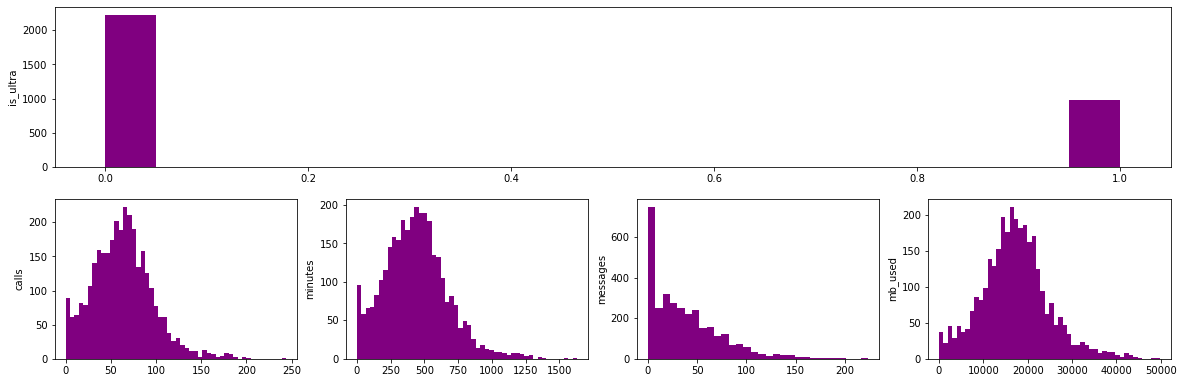

In [6]:
# отобразим данные на графиках
fig = plt.figure(figsize=(20, 10))

df['is_ultra'].sort_values(ascending=True).plot.hist(ax=plt.subplot2grid((3,4),(0,0),colspan=4), color = 'purple', bins = 20).set(ylabel='is_ultra');
df['calls'].sort_values(ascending=True).plot.hist(ax=plt.subplot2grid((3,4), (1,0), colspan=1), color = 'purple', bins = 50).set(ylabel='calls');
df['minutes'].sort_values(ascending=True).plot.hist(ax=plt.subplot2grid((3,4), (1,1), colspan=1), color = 'purple', bins = 50).set(ylabel='minutes');
df['messages'].sort_values(ascending=True).plot.hist(ax=plt.subplot2grid((3,4), (1,2), colspan=1), color = 'purple', bins = 30).set(ylabel='messages');
df['mb_used'].sort_values(ascending=True).plot.hist(ax=plt.subplot2grid((3,4), (1,3), colspan=1), color = 'purple', bins = 50).set(ylabel='mb_used');

In [7]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [8]:
# количество объектов (сторок) и признаков (столбцов)
df.shape

(3214, 5)

### 1.1. Описание данных

**Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:**
* **сalls** — количество звонков,
* **minutes** — суммарная длительность звонков в минутах,
* **messages** — количество sms-сообщений,
* **mb_used** — израсходованный интернет-трафик в Мб,
* **is_ultra** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## 2. Разделим исходные данные на выборки и извлечем признаки для каждой из них

* **df_train** - обучающая выборка (**60%** исходных данных)
* **df_valid** - валидационная выборка (**20%** исходных данных)
* **df_test** - тестовая выборка (**20%** исходных данных)

### 2.1. На первом шаге разделим данные на обучающую + валидационную и тестовую выборки

In [9]:
# отделяем 20% данных для тестовой выборки
train_valid, df_test = train_test_split(df, test_size=0.2, random_state=12345) 

### 2.1. На втором шаге разделим обучающую и валидационную выборки

In [10]:
# отделяем 25% данных от обучающей+валидационной, чтобы в валидационной получилось 20% от исходных данных
df_train, df_valid = train_test_split(train_valid, test_size=0.25, random_state=12345)

### 2.2. Проверим распределение выборок

In [11]:
# обучающая выборка - 60% от исходных данных
df_train.shape

(1928, 5)

In [12]:
# валидационная выборка - 20% от исходных данных
df_valid.shape

(643, 5)

In [13]:
# тестовая выборка - 20% от исходных данных
df_test.shape

(643, 5)

### 2.3. Извлечем признаки для каждой выборки

In [14]:
# переменные (признаки) обучающей выборки
features_train = df_train.drop(['is_ultra'], axis=1)
# целевой признак обучающей выборки
target_train = df_train['is_ultra']

In [15]:
# проверим результат
print(features_train.shape)
print(target_train.shape)

(1928, 4)
(1928,)


In [16]:
# переменные (признаки) валидационной выборки
features_valid = df_valid.drop(['is_ultra'], axis=1)
# целевой признак валидационной выборки
target_valid = df_valid['is_ultra']

In [17]:
# проверим результат
print(features_valid.shape)
print(target_valid.shape)

(643, 4)
(643,)


In [18]:
# переменные (признаки) тестовой выборки
features_test = df_test.drop(['is_ultra'], axis=1)
# целевой признак тестовой выборки
target_test = df_test['is_ultra']

In [19]:
# проверим результат
print(features_test.shape)
print(target_test.shape)

(643, 4)
(643,)


## 3. Исследуем качество разных моделей

### 3.1. Модель "Логистическая регрессия"

In [20]:
# создадим модель с алгоритмом 'lbfgs', сохраним её в переменной и зафиксируем псевдослучайность для алгоритма обучения (random_state=12345)
logreg_model = LogisticRegression(random_state=12345, solver='lbfgs')

In [21]:
# обучим модель
logreg_model.fit(features_train, target_train)

LogisticRegression(random_state=12345)

In [22]:
# оценка правильности предсказаний модели на обучающей выборке 
accuracy_train = logreg_model.score(features_train, target_train)

# оценка правильности предсказаний модели на валидационной выборке
accuracy_valid = logreg_model.score(features_valid, target_valid)

print("Accuracy - обучающая выборка:", f'{accuracy_train:.3f}')
print("Accuracy - валидационная выборка:", f'{accuracy_valid:.3f}')

Accuracy - обучающая выборка: 0.751
Accuracy - валидационная выборка: 0.726


#### Выводы:

1. Показатель правильности модели "Логистическая регрессия" низок для обучающей выбороки, на валидационной не перевысил прогового значения accuracy > 0.75
2. Это проблема недообучения, вероятно, связанная со особенностями модели.
3. Изменения значений гиперпараметров модели "Логистическая регрессия" для поиска лучшего значения accuracy не дали резльтатата > 0.75
4. При получении неудовлетворительного результата, рекомендуется переходить к более сложным, но обычно более точным моделям.

### 3.2. Модель "Дерево решений"

In [23]:
# создадим модель, сохраним её в переменной и зафиксируем псевдослучайность для алгоритма обучения (random_state=12345)
tree_model = DecisionTreeClassifier(random_state=12345)

In [24]:
# обучим модель
tree_model.fit(features_train, target_train)

DecisionTreeClassifier(random_state=12345)

In [25]:
# получим предсказания модели на обучающей выборке 
predictions_train = tree_model.predict(features_train)

# оценка правильности предсказаний модели на обучающей выборке
accuracy_train = accuracy_score(target_train, predictions_train)

# получим предсказания модели на валидационной выборке
predictions_valid = tree_model.predict(features_valid)

# оценка правильности предсказаний модели на тестовой выборке
accuracy_valid = accuracy_score(target_valid, predictions_valid)

print("Accuracy - обучающая выборка:", f'{accuracy_train:.3f}')
print("Accuracy - валидационная выборка:", f'{accuracy_valid:.3f}')

Accuracy - обучающая выборка: 1.000
Accuracy - валидационная выборка: 0.712


#### Выводы:

1. На обучающей выборке модель предсказывает лучше, чем на валидационной.
2. Это проблема переобучения, значит модель плохо поняла зависимости в данных.
3. Изменим значения параметра максимальной глубины дерева (max_depth) для поиска лучшего значения accuracy.

#### 3.2.1. Проведем оценку правильности модели "Дерево решений" с различными значением глубины дерева и выберем модель с лучшим показателем Accuracy

In [26]:
# проверим  max_depth от 1 до 50

x_depth = []                                                                 # список для графика ось х
y_result = []                                                                # ось y

best_tree_model = None
best_result = 0

for depth in range(1, 51):
    tree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # создадим модель с заданной глубиной дерева от 1 до 50
    tree_model.fit(features_train, target_train)                             # обучим модель на обучающей выборке
    predictions_valid = tree_model.predict(features_valid)                   # найдём предсказания на валидационной выборке
    result = accuracy_score(target_valid, predictions_valid)                 # посчитаем качество модели на валидационной выборке
    
    x_depth.append(depth)                                                    # собираем списки для графика
    y_result.append(result)
    
    if result > best_result:
        best_tree_model = tree_model
        best_result = result
        
print("Accuracy лучшей модели:", f'{best_result:.3f}')
best_tree_model
    #print("max_depth =", depth, ": ", end='')
    #print(result)                                                            # выведем значения максимальнай глубины и accuracy

Accuracy лучшей модели: 0.774


DecisionTreeClassifier(max_depth=7, random_state=12345)

In [27]:
%%time
# определяем параметры для перебора

parametrs = {'max_depth': range (1, 51, 1)} # глубина от 1 до 12 с шагом 1
# запускаем обучение
grid = GridSearchCV(tree_model, parametrs, cv=5)
grid.fit(features_train, target_train)

# выводим результат
grid.best_params_

CPU times: total: 1.47 s
Wall time: 1.46 s


{'max_depth': 3}

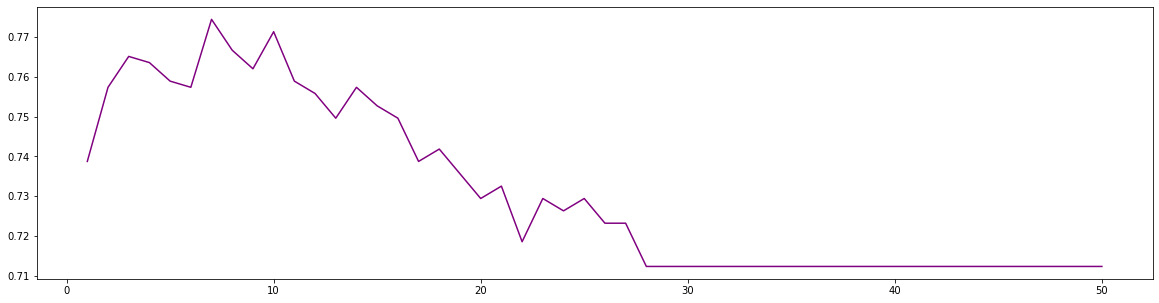

In [28]:
# отобразим значения Accuracy на графике

fig = plt.figure(figsize=(20, 5))
plt.plot(x_depth, y_result, color ='purple');

#### 3.2.2. Выберем модель "Дерево решений" с лучшим показателем Accuracy

In [29]:
best_tree_model = None
best_result = 0
for depth in range(1, 16):
     tree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)  # создадим модель с заданной глубиной дерева от 1 до 15
     tree_model.fit(features_train, target_train)                              # обучим модель на обучающей выборке
     predictions_valid = tree_model.predict(features_valid)                    # получаем предсказания модели
     result = accuracy_score(target_valid, predictions_valid)                  # считаем качество модели
     if result > best_result:
         best_tree_model = tree_model
         best_result = result
         
print("Accuracy лучшей модели:", f'{best_result:.3f}')
best_tree_model

Accuracy лучшей модели: 0.774


DecisionTreeClassifier(max_depth=7, random_state=12345)

#### Выводы:

1. Accuracy лучшей модели на валидационной выборке: 0.774 с глубиной дерева - 7 (max_depth=7)
2. Изменение гиперпараметров модели - criterion='gini', min_samples_split и min_samples_leaf не улучшили показатель правильности  

### 3.3. Модель "Случайный лес"

In [30]:
# создадим модель, сохраним её в переменной и зафиксируем псевдослучайность для алгоритма обучения (random_state=12345)
forest_model = RandomForestClassifier(random_state=12345)

In [31]:
# обучим модель
forest_model.fit(features_train, target_train)

RandomForestClassifier(random_state=12345)

#### 3.3.1. Оценим правильность предсказания модели методом score()

In [32]:
# оценка правильности предсказаний модели на обучающей выборке 
accuracy_train = forest_model.score(features_train, target_train)

# оценка правильности предсказаний модели на валидационной выборке
accuracy_valid = forest_model.score(features_valid, target_valid)

print("Accuracy - обучающая выборка:", accuracy_train)
print("Accuracy - валидационная выборка:", accuracy_valid)

Accuracy - обучающая выборка: 1.0
Accuracy - валидационная выборка: 0.7947122861586314


#### Выводы:

1. На валидационной выборке модель "Случайный лес" предсказывает лучше, чем лучшая модель "Дерево решений".
2. Цель: accuracy > 0.75 достигнута.
3. Увеличим количество деревьев, изменив значение гиперпараметра n_estimators для поиска лучшего значения accuracy.

#### 3.3.2. Проведем оценку правильности модели с различными значением гиперпараметра n_estimators

In [33]:
%%time

best_forest_model = None
best_result = 0
# цикл обучения модели с разным количеством деревьев от 1 до 100
for est in range(1, 101):
    forest_model = RandomForestClassifier(random_state=12345, n_estimators=est) # создадим модель с заданным количеством деревьев
    forest_model.fit(features_train, target_train)                              # обучим модель используя обучающую выборку
    
    result = forest_model.score(features_valid, target_valid)                   # посчитайте качество модели на валидационной выборке
    
    if result > best_result:                                                    # сравним результат 
        best_forest_model = forest_model                                        # сохраним наилучшую модель
        best_result = result                                                    # сохраним наилучшее значение метрики accuracy на валидационных данных

print("Accuracy наилучшей модели на валидационной выборке:", f'{best_result:.3f}')
best_forest_model

Accuracy наилучшей модели на валидационной выборке: 0.799
CPU times: total: 22 s
Wall time: 22.1 s


RandomForestClassifier(n_estimators=65, random_state=12345)

Создаем словарик, в который вписываем параметры, которые будем прогонять GridSearch’ем.\
Для примера будем использовать следующие параметры:

- n_estimators – число деревьев в лесу. Оно будет изменяться от 10 до 50 с шагом 10

- max_depth – глубина дерева. Она будет изменяться от 1 до 12 с шагом в 2

- min_samples_leaf – минимальное число образцов в листах. Оно будет изменяться от 1 до 7

- min_samples_leaf – минимальное число образцов для сплита. Оно будет изменяться от 2 до 9

In [34]:
%%time
# определяем параметры для перебора

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 13, 2),
              'min_samples_leaf': range (1, 8),
              'min_samples_split': range (2, 10, 2) }
# запускаем обучение
grid = GridSearchCV(forest_model, parametrs, cv=5)
grid.fit(features_train, target_train)

# выводим результат
grid.best_params_

CPU times: total: 4min 59s
Wall time: 5min


{'max_depth': 9,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'n_estimators': 10}

#### Выводы:

1. Accuracy лучшей модели "Случайный лес" на валидационной выборке: 0.799 с количеством деревьев - 65 (n_estimators=65)
2. Показатель правильности модели "Случайный лес" лучше, показатели лучше модели "Дерево решений", однако поиск лучшей модели "Случайный лес" более ресурсоёмкий   


## 4. Проверим качество модели на тестовой выборке

### 4.1. Лучшая модель "Случайный лес"

In [35]:
best_forest_model = RandomForestClassifier(n_estimators=65, random_state=12345) # Accuracy = 0.790

In [36]:
# best_forest_model = RandomForestClassifier(max_depth=9, min_samples_leaf=6, min_samples_split=2, n_estimators=10, random_state=12345) # Accuracy = 0.799

In [37]:
# обучим модель
best_forest_model.fit(features_train, target_train)

RandomForestClassifier(n_estimators=65, random_state=12345)

### 4.2. Оценим Accuracy на тестовой выборке

In [38]:
# оценка правильности предсказаний модели на тестовой выборке 

accuracy_test_forest = best_forest_model.score(features_test, target_test)
print("Accuracy best_forest_model тестовая выборка:",  f'{accuracy_test_forest:.3f}')

Accuracy best_forest_model тестовая выборка: 0.790


#### Выводы:

1. Accuracy лучшей модели "Случайный лес" на тестовой выборке: 0.790, что немного меньше, чем на валидационной.
2. Для дальнейшего исследования рекомендуется использовать модель "Случайный лес" с гиперпараметрами RandomForestClassifier(n_estimators=65, random_state=12345)  


## Выводы:
**1. Модель "Логистическая регрессия**
- Показатель правильности модели "Логистическая регрессия" на валидационной выборке не перевысил прогового значения accuracy > 0.75;
- Изменения значений гиперпараметров модели "Логистическая регрессия" для поиска лучшего значения accuracy не дали резльтатата > 0.75;
- Для дальнейшего исследования использовались более сложные модели "Дерево решений" и "Случайный лес".

**2. Модель "Дерево решений"**
- Accuracy лучшей модели "Дерево решений" на валидационной выборке: 0.774 с глубиной дерева - 7 (max_depth=7);
- Изменение других гиперпараметров этой модели не улучшили accuracy.  

**3. Модель "Случайный лес"**
- Accuracy лучшей модели "Случайный лес" на валидационной выборке: 0.799 с количеством деревьев - 65 (n_estimators=65);
- Показатель правильности модели "Случайный лес" лучше, показатели лучше модели "Дерево решений", однако поиск лучшей модели "Случайный лес" более ресурсоёмкий

**4. Сравнение моделей на тестовой выборке**
- Accuracy лучшей модели "Случайный лес на тестовой выборке: 0.790
- Для дальнейшего исследования рекомендуется использовать модель "Случайный лес" с гиперпараметрами RandomForestClassifier(n_estimators=65, random_state=12345)

## 5. Дополнительное задание: проверить модели на вменяемость

In [39]:
# создаем модель для сравнения с более сложными моделями "Случайный лес" и "Дерево решений"
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345 )

In [40]:
# обучаем на обучающей выборке   
dummy_clf.fit(features_train, target_train)

DummyClassifier(random_state=12345, strategy='most_frequent')

In [41]:
# оцениим модель методом score()
accuracy_dummy_clf = dummy_clf.score(features_train, target_train)
print("Accuracy dummy_clf на обучающей выборке:",  f'{accuracy_dummy_clf:.3f}')

Accuracy dummy_clf на обучающей выборке: 0.695


#### Выводы:

1. Accuracy "DummyClassifier" 0.695
2. Поскольку accuracy наших моделей больше, то можно сделать вывод - модели работают лучше и делают прогноз точнее, чем простой классификатор.    